In [1]:
import pandas as pd
import numpy as np
import math
from numpy import sqrt, radians, arcsin, sin, cos
import matplotlib.pyplot as plt

from geospatial import *

In [2]:
def buffer_points(points, buffer_size):
    """
    Point-Buffer
    inputs:
    - points: list of tuples with x and y coordinates
    - buffer_size: size of buffer as float or int
    output:
    - list of points (not ordered)
    """
    buffered_points = []
    #Creates point objects for list of points
    for point in points:
        x = point.x
        y = point.y
        
        # Create a circle of points around the original point
        angles = np.linspace(0, 2*np.pi, num=7)
        circle_points = [Point(x + buffer_size*np.cos(a), y + buffer_size*np.sin(a)) for a in angles[:-1]]
        
        buffered_points += circle_points
    #Returns a list of point objects
    return buffered_points

Sources:  

Figueira, João Paulo (2018): The Concave Hull. In: Towards Data Science, URL:(< https://towardsdatascience.com/the-concave-hull-c649795c0f0f>, last accessed: 2023-06-04). 

Lin, Michael Robert (2019): Concave-Hull. URL:(< https://github.com/M-Lin-DM/Concave-Hulls >, last accessed: 06.06.2023) 

In [1]:
class ConcaveHull(object):

    def __init__(self, points, k, verbose=False):
        if isinstance(points, np.core.ndarray):
            self.data_set = points
        elif isinstance(points, list):
            self.data_set = np.array(points)
        else:
            raise ValueError('Please provide an [N,2] numpy array or a list of lists.')

        # Clean up duplicates
        self.data_set = np.unique(self.data_set, axis=0)

        # Creats the initial index, as an array of bools (0 or 1)
        self.indices = np.ones(self.data_set.shape[0], dtype=bool)  
        
        self.k = k
        self.verbose = verbose

    @staticmethod
    def dist_pt_to_group(a, b):  
        # a is the group ([n, 2]-array) , b is the current point ([1, 2]-array)
        d = np.sqrt(np.sum(np.square(np.subtract(a, b)), axis=1))
        return d

    @staticmethod
    def get_lowest_latitude_index(points):
        #orders by lowest latutide, and returns point with lowest latitude
        indices = np.argsort(points[:, 1])
        return indices[0]

    @staticmethod
    def norm_array(v):  
        #normalization of several vectors
        norms = np.array(np.sqrt(np.sum(np.square(v), axis=1)), ndmin=2).transpose()
        return np.divide(v, norms)

    @staticmethod
    def norm(v):  
        #normalization of one vactor
        return v / np.linalg.norm(v)

    def get_k_nearest(self, ix, k):
        """
        Calculates the k nearest point indices to the point indexed by ix
        :param ix: Index of the starting point
        :param k: Number of neighbors to consider
        :return: Array of indices into the data set array
        """
        ixs = self.indices
        #base_indices gets the indices of the points which are still labeled true (= still available for calculations)
        base_indices = np.arange(len(ixs))[ixs]
        #the indices are now used to calculate the next nearest neightbors to the current point (starting point) 
        distances = self.dist_pt_to_group(self.data_set[ixs, :], self.data_set[ix, :])
        sorted_indices = np.argsort(distances)
        
        kk = min(k, len(sorted_indices))
        k_nearest = sorted_indices[range(kk)]
        return base_indices[k_nearest]

    def clockwise_angles(self, last, ix, ixs, first):  # last needs to be the index of the previous current point
        if first == 1:
            last_norm = np.array([-1, 0], ndmin=2)
        elif first == 0:
            # normalized vector pointing towards previous point
            last_norm = self.norm(np.subtract(self.data_set[last, :], self.data_set[ix,:]))  
        
        # normalized row vectors pointing to set of k nearest neibs
        ixs_norm = self.norm_array(np.subtract(self.data_set[ixs, :], self.data_set[ix,:]))  
        
        #ang is created as a [ixs, 1]-array to store the angles
        ang = np.zeros((ixs.shape[0], 1))
        for j in range(ixs.shape[0]):
            theta = np.arccos(np.dot(last_norm, ixs_norm[j, :]))
            z_comp = np.cross(last_norm, ixs_norm[j, :])
            
            if z_comp <= 0:
                ang[j, 0] = theta
            elif z_comp > 0:
                ang[j, 0] = 2 * np.pi - theta
        return np.squeeze(ang)

    def recurse_calculate(self):
        """
        Calculates the concave hull using k=k+1
        """
        recurse = ConcaveHull(self.data_set, self.k + 1)
        if recurse.k >= self.data_set.shape[0]:
            if self.verbose == True:
                print(" max k reached, at k={0}".format(recurse.k))
            return None
        if self.verbose == True:
            print("k={0}".format(recurse.k))
        return recurse.calculate()

    def calculate(self):
        """
        Calculates the convex hull of the data set as an array of points
        :return: Array of points (N, 2) with the concave hull of the data set
        """
        if self.data_set.shape[0] < 3:
            return None

        if self.data_set.shape[0] == 3:
            return self.data_set

        # Make sure that k neighbors can be found
        kk = min(self.k, self.data_set.shape[0])

        first_point = self.get_lowest_latitude_index(self.data_set)
        current_point = first_point

        # Initiation of hull and testhull as [n, 2]-matrices
        hull = np.reshape(np.array(self.data_set[first_point, :]), (1, 2))
        test_hull = hull

        # Remove the first point from the index, so that its not considered in further calculations
        self.indices[first_point] = False

        step = 2
        stop = 2 + kk
        
        #executes while loop as long as the hull is not closed and there are points left to consider
        while ((current_point != first_point) or (step == 2)) and len(self.indices[self.indices]) > 0:  
            if step == stop:
                self.indices[first_point] = True
            #Gets the indices of the k-nearest-neighbours as a list
            knn = self.get_k_nearest(current_point, kk)  

            if step == 2:
                angles = self.clockwise_angles(1, current_point, knn, 1)
            else:
                # Calculates the headings between first_point and the knn points
                # Returns angles in the same indexing sequence as in knn
                angles = self.clockwise_angles(last_point, current_point, knn, 0)

            # Calculate the candidate indexes (largest angles first -> rightmost first). 
            candidates = np.argsort(-angles)

            i = 0
            invalid_hull = True
            geospatial_invalid_hull = True
            while geospatial_invalid_hull and i < len(candidates):
                candidate = candidates[i]
                
                # Create test hull and check for intersection with segment formed by candidate
                next_point = np.reshape(self.data_set[knn[candidate], :], (1, 2))
                geospatial_test_hull = hull
                line = PLinestring(geospatial_test_hull)
                geospatial_invalid_hull = line.string_segment_intersection(Segment(Point(geospatial_test_hull[-1,0],geospatial_test_hull[-1,1]), Point(next_point[:, 0][0], next_point[:, 1][0])))  
                # geospatial_invalid_hull will turn to False as soon as a candidate, that creates a valid linestring with the
                # existing hull is found
                i += 1

            if geospatial_invalid_hull:
                if self.verbose == True:
                    print("invalid hull for all nearest neibs")
                return self.recurse_calculate()
            
            #Add chosen candidate to the hull
            last_point = current_point  
            current_point = knn[candidate] 
            hull = np.append(geospatial_test_hull, next_point, axis=0)
            # Newly found point is removed from the list (such that it is not included in knn anymore)
            self.indices[current_point] = False 
            step += 1
            
        
        poly = Polygon(hull, 0, 1)
        count = 0
        total = self.data_set.shape[0]
        for ix in range(total):
            #Creates a point object of a node
            pt = Point(self.data_set[ix, 0], self.data_set[ix, 1])
            #Checks if all points are contained in the hull (or on the edge of it)
            if (poly.intersectsPoint(pt)): 
                count += 1
            if self.verbose == True:
                print("point not in polygon")
        
        #If all points are contained in the hull, the algorithm ends and returns the hull as a [n, 2]-array
        if count == total:
            return hull
        else:
            return self.recurse_calculate()

In [4]:
def buffer(nodes,dist, nn, reduction = 0, verbose=False):
    """
    (Linestring-)Buffer
    Combines point buffer function and concave hull method

    inputs:
    - node: List of Point objects, which represent a linestring
    - dist: Size of Buffer in meters (e.g. 200)
    - nn: With how many nearest neighbors the calculation should start (recommended: 20)
    - reduction: By how much the linstring should be reduced (e.g. 50 means, the algorithm will take into account
    every 50th point of the linestring)

    output:
    - [n, 2]-array (in first position x-coordinate, in second position y-coordinate)

    """
    #Reduction of nodes
    if reduction!=0:
        nodes = nodes[::reduction]
    node_buffer = buffer_points(nodes, dist)
    
    #Creates a list of lists as input for concave hull class
    node_buffer_list = [[node.x, node.y] for node in node_buffer]
    
    #Calculate hull
    hull_object = ConcaveHull(node_buffer_list,nn, verbose)
    hull = hull_object.calculate()
    
    #Hull is a Polygon
    return Polygon(hull, 0, 1)

## Demo

In [5]:
#Loading sample data from disk
myHighway = pd.read_csv("data\A1Sample_20230529_nnitsi.csv")

#Transform into suitable input
highway_nodes = []
for index, row in myHighway.iterrows():
    obj = Point(row['x'], row['y'])
    highway_nodes.append(obj)

#Function call
sample = buffer(highway_nodes,500,20, 50)
type(sample)

geospatial.Polygon

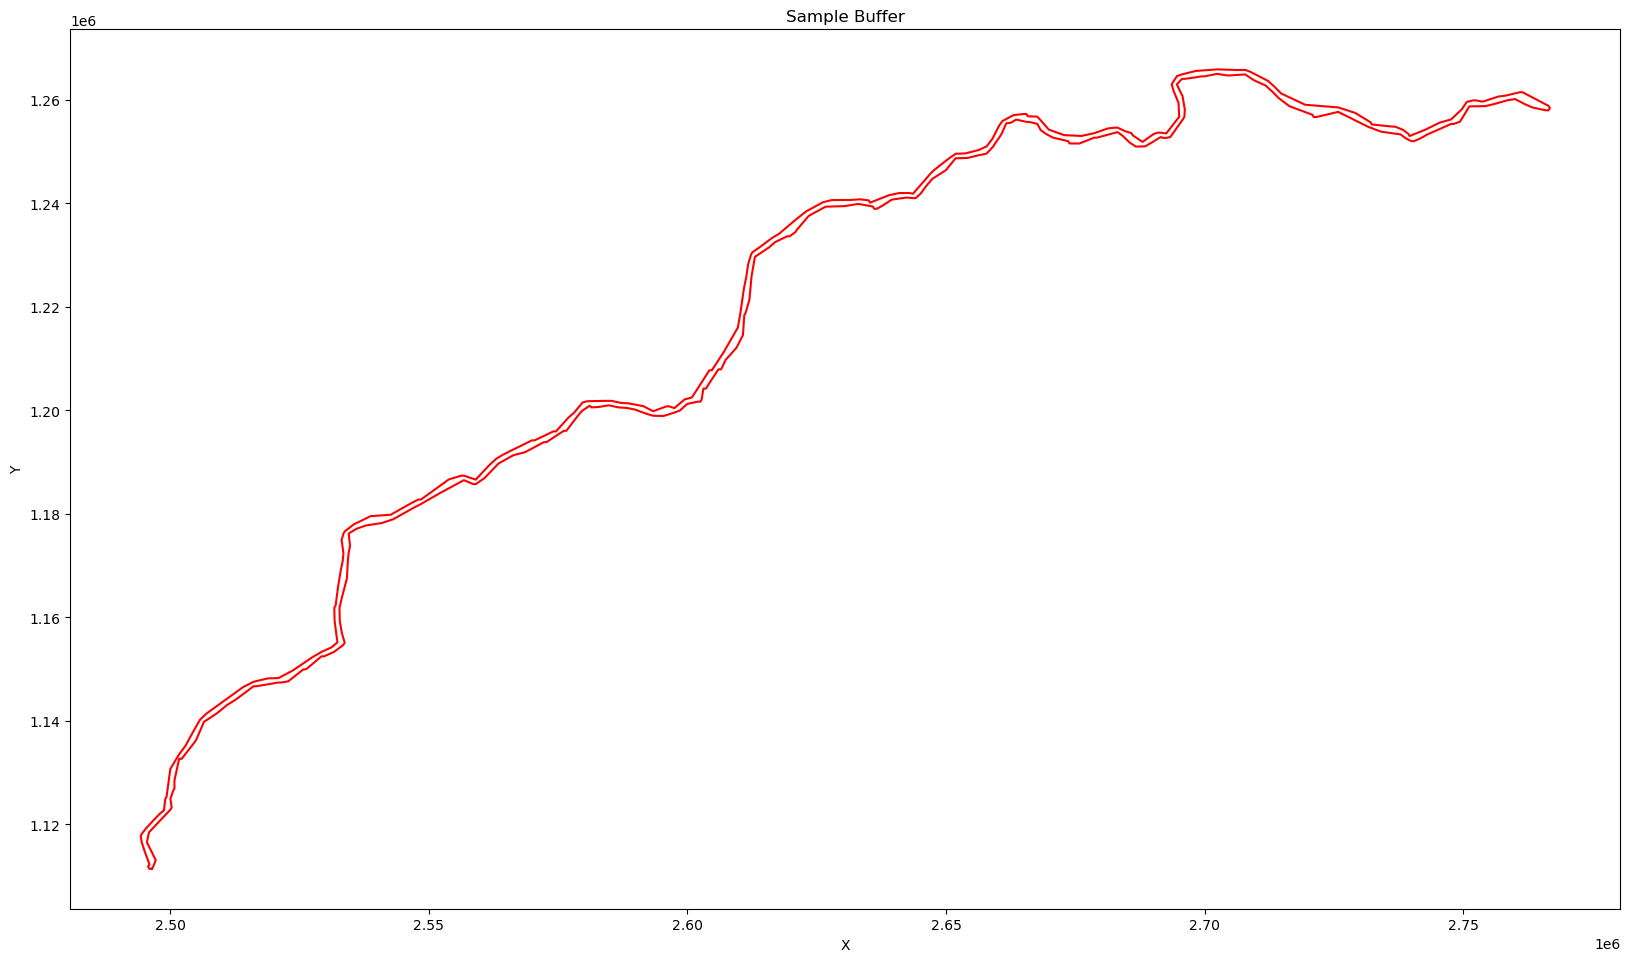

In [6]:
fig, ax0 = plt.subplots(figsize = (20,20))

ax0.plot([i.x for i in sample],[i.y for i in sample], color = 'red')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_title('Sample Buffer')
ax0.set_aspect('equal')